In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import os


In [2]:
import torch

if torch.cuda.is_available():
    print(f" CUDA is available!")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"Total GPUs: {torch.cuda.device_count()}")
else:
    print(" CUDA not available. Go to 'Settings' in the right sidebar and change 'Accelerator' to GPU.")

✅ CUDA is available!
GPU Device: Tesla T4
Total GPUs: 2


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import pandas as pd
import os

class PartsDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

        self.image_col = "image_name"
        self.target_cols = self.df.columns[1:]
        self.df[self.target_cols] = self.df[self.target_cols].fillna(0)
        for col in self.target_cols:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce').astype('int32')
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(
            self.img_dir,
            self.df.iloc[idx][self.image_col]
        )

        image = Image.open(img_path).convert("RGB")

        targets = torch.tensor(
            self.df.iloc[idx][self.target_cols].values.astype('float32'), # Force cast here
            dtype=torch.float32
        )

        if self.transform:
            image = self.transform(image)

        return image, targets


In [5]:
import inspect
print(inspect.signature(PartsDataset))


(csv_path, img_dir, transform=None)


In [6]:
def build_dataloader(csv_path, img_dir, transform, batch_size, shuffle):
    dataset = PartsDataset(csv_path, img_dir, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [8]:
def build_model(num_outputs):
    model = models.efficientnet_b0(weights="IMAGENET1K_V1")

    in_features = model.classifier[1].in_features
    model.classifier = nn.Linear(in_features, num_outputs)

    return model


In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, targets in dataloader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [10]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [11]:
def run_training(model, train_loader, val_loader, epochs, lr, device):
    model.to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss = validate(
            model, val_loader, criterion, device
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train MAE: {train_loss:.3f} | "
            f"Val MAE: {val_loss:.3f}"
        )

    return train_losses, val_losses


In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("/kaggle/input/nuts-and-bolts/train_labels.csv")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)


In [13]:
import torchvision.transforms.functional as TF

def run_inference_tta(model, test_img_dir, test_transform, device):
    model.eval()
    predictions = []
    images = [f for f in os.listdir(test_img_dir) if f.endswith('.png')]
    
    with torch.no_grad():
        for img_name in images:
            img_path = os.path.join(test_img_dir, img_name)
            img_raw = Image.open(img_path).convert('RGB')
            
            # Create 4 versions of the same image
            # We transform them AFTER flipping to keep normalization consistent
            img1 = test_transform(img_raw).unsqueeze(0).to(device)
            img2 = test_transform(TF.hflip(img_raw)).unsqueeze(0).to(device)
            img3 = test_transform(TF.vflip(img_raw)).unsqueeze(0).to(device)
            img4 = test_transform(TF.hflip(TF.vflip(img_raw))).unsqueeze(0).to(device)
            
            # Get 4 predictions
            out1 = model(img1)
            out2 = model(img2)
            out3 = model(img3)
            out4 = model(img4)
            
            # Average the raw scores BEFORE rounding
            avg_output = (out1 + out2 + out3 + out4) / 4.0
            pred = avg_output.cpu().numpy().round().astype(int).flatten()
            
            predictions.append([img_name] + pred.tolist())
            
    return predictions

In [14]:
def save_predictions_to_csv(predictions, output_path):
    df = pd.DataFrame(predictions)
    df.to_csv(output_path, index=False)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s] 


Epoch 1/20 | Train MAE: 0.314 | Val MAE: 0.245
Epoch 2/20 | Train MAE: 0.194 | Val MAE: 0.167
Epoch 3/20 | Train MAE: 0.158 | Val MAE: 0.112
Epoch 4/20 | Train MAE: 0.136 | Val MAE: 0.109
Epoch 5/20 | Train MAE: 0.117 | Val MAE: 0.089
Epoch 6/20 | Train MAE: 0.105 | Val MAE: 0.077
Epoch 7/20 | Train MAE: 0.096 | Val MAE: 0.081
Epoch 8/20 | Train MAE: 0.091 | Val MAE: 0.078
Epoch 9/20 | Train MAE: 0.086 | Val MAE: 0.062
Epoch 10/20 | Train MAE: 0.084 | Val MAE: 0.096
Epoch 11/20 | Train MAE: 0.081 | Val MAE: 0.066
Epoch 12/20 | Train MAE: 0.080 | Val MAE: 0.089
Epoch 13/20 | Train MAE: 0.076 | Val MAE: 0.057
Epoch 14/20 | Train MAE: 0.074 | Val MAE: 0.066
Epoch 15/20 | Train MAE: 0.073 | Val MAE: 0.074
Epoch 16/20 | Train MAE: 0.072 | Val MAE: 0.069
Epoch 17/20 | Train MAE: 0.068 | Val MAE: 0.065
Epoch 18/20 | Train MAE: 0.068 | Val MAE: 0.047
Epoch 19/20 | Train MAE: 0.073 | Val MAE: 0.050
Epoch 20/20 | Train MAE: 0.061 | Val MAE: 0.056

Training completed
Final Train MAE: 0.0613
Final

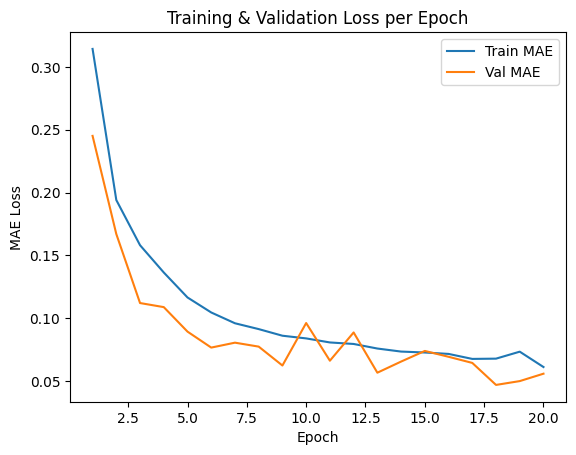

In [15]:

train_loader = build_dataloader(
    csv_path="/kaggle/working/train_split.csv",
    img_dir="/kaggle/input/nuts-and-bolts/train/train",
    transform=train_transform,
    batch_size=16,
    shuffle=True
)


val_loader = build_dataloader(
    csv_path="/kaggle/working/val_split.csv",
    img_dir="/kaggle/input/nuts-and-bolts/train/train",
    transform=test_transform,
    batch_size=16,
    shuffle=False
)

num_outputs = len(pd.read_csv("/kaggle/working/train_split.csv").columns) - 1


model = build_model(num_outputs)

train_losses,val_losses=run_training(
    model,
    train_loader,
    val_loader,
    epochs=20,
    lr=3e-4,
    device=device
)
print("\n==============================")
print("Training completed")
print(f"Final Train MAE: {train_losses[-1]:.4f}")
print(f"Final Val MAE:   {val_losses[-1]:.4f}")
print("==============================\n")

# ---- Plot loss curves ----
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train MAE")
plt.plot(epochs, val_losses, label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.show()


In [16]:
train_df.info()
best_val = float("inf")

torch.save(model.state_dict(), "/kaggle/working/best_model.pth")


<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   8000 non-null   object
 1   bolt         8000 non-null   int64 
 2   locatingpin  8000 non-null   int64 
 3   nut          8000 non-null   int64 
 4   washer       8000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 375.0+ KB


In [17]:
import torch
import pandas as pd
import numpy as np
import os

from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [18]:
num_outputs = len(pd.read_csv("/kaggle/working/train_split.csv").columns) - 1

model = build_model(num_outputs)
model.load_state_dict(
    torch.load("/kaggle/working/best_model.pth", map_location=device)
)
model.to(device)
model.eval()

print(" Model loaded")


✅ Model loaded


In [20]:


import torch
import pandas as pd
import numpy as np
import os
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# -------- Device --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Load model --------
# Note: Ensure build_model and test_transform are defined in a previous cell
num_outputs = len(pd.read_csv("/kaggle/working/train_split.csv").columns) - 1

model = build_model(num_outputs)
model.load_state_dict(
    torch.load("/kaggle/working/best_model.pth", map_location=device)
)
model.to(device)
model.eval()

print("Model loaded")

# -------- Test Dataset --------
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # List all image files
        self.image_names = [
            f for f in os.listdir(img_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# -------- DataLoader --------
# Ensure this path points exactly to the folder containing the .png files
test_img_dir = "/kaggle/input/nuts-and-bolts/test" 

test_dataset = TestDataset(
    img_dir=test_img_dir,
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

# -------- Inference with TTA --------
rows = []
print(f" Running TTA Inference on {len(test_dataset)} images...")

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        
        # 1. Original Pass
        out1 = model(images)
        
        # 2. Horizontal Flip Pass
        out2 = model(TF.hflip(images))
        
        # 3. Vertical Flip Pass
        out3 = model(TF.vflip(images))
        
        # 4. Both Flips Pass
        out4 = model(TF.hflip(TF.vflip(images)))
        
        # Average the raw model scores (logits) before rounding
        avg_out = (out1 + out2 + out3 + out4) / 4.0
        
        # Convert to rounded integers
        preds = avg_out.cpu().numpy().round().astype(int)
        
        # Store results
        for name, pred in zip(names, preds):
            rows.append([name] + pred.tolist())

print(f"Inference completed: {len(rows)} rows processed")

# -------- Build & Align submission --------
sample_df = pd.read_csv("/kaggle/input/samplesubmission/sample_submission.csv")
column_names = sample_df.columns.tolist()

# Create initial DataFrame
temp_df = pd.DataFrame(rows, columns=column_names)

# CRITICAL: Re-index to match the EXACT row order of sample_submission.csv
submission_df = temp_df.set_index('image_name').reindex(sample_df['image_name']).reset_index()

# Fill any missing images with 0 (just in case) and ensure they are integers
submission_df = submission_df.fillna(0)
submission_df.iloc[:, 1:] = submission_df.iloc[:, 1:].astype(int)

# -------- Save CSV --------
output_path = "/kaggle/working/finalsubmission.csv"
submission_df.to_csv(output_path, index=False)

print("finalsubmission2.csv saved and aligned to sample order")

# -------- Sanity checks --------
print(submission_df.head())
assert submission_df["image_name"].is_unique
print("Unique image names confirmed")

✅ Model loaded
 Running TTA Inference on 2000 images...
Inference completed: 2000 rows processed
finalsubmission2.csv saved and aligned to sample order
                             image_name  bolt  locatingpin  nut  washer
0  29f1336386444b9cacb1094a9b102fc6.png     1            0    0       0
1  666bc0ffc1fe43f2881d7eefb2411654.png     0            1    1       1
2  718a1d44bc074fe790b1dd9d23cce88c.png     1            0    0       1
3  4428d43d305a4aa68632cfa437987294.png     0            0    1       2
4  f7fca0d7df4c4423b00c98ce4eed64a7.png     1            1    1       1
Unique image names confirmed
